# Model Fitting and Analysis

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import altair as alt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)

alt.data_transformers.disable_max_rows()
alt.data_transformers.enable("data_server")

alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### Data Import (Previous Script)

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv"
)
#df = df[(df.annual_salary < 1000000) & (df.annual_salary > 10000)]
#df["state"] = df["state"].mask(df["state"].map(df["state"].value_counts()) < 5, "")
#df["city"] = df["city"].mask(df["city"].map(df["city"].value_counts()) < 5, "")
#df.fillna({"industry":"", "job_title":""}, inplace=True)
df.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600,4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [4]:
df_dropcurrency = df[df["currency"] == "USD"].drop(
    columns=["currency", "currency_other"]
)
df_dropcountry = df_dropcurrency[
    df_dropcurrency["country"]
    .str.lower()
    .isin(
        [
            "us",
            "usa",
            "u.s.",
            "u.s.a",
            "united states",
            "america",
            "united states of america",
        ]
    )
].drop(columns=["country", "gender", "race", "timestamp"])

# split the data before EDA
train_df, test_df = train_test_split(df_dropcountry, test_size=0.3, random_state=123)

### Data Processing (Script 1)

In [5]:
# filter and split the data
train_df = train_df[(train_df["annual_salary"] < 1000000) & (train_df["annual_salary"] > 10000)]
train_df["state"] = train_df["state"].mask(train_df["state"].map(train_df["state"].value_counts()) < 5, "")
train_df["city"] = train_df["city"].mask(train_df["city"].map(train_df["city"].value_counts()) < 5, "")

train_df.fillna({"industry":"", "job_title":""}, inplace=True)
test_df.fillna({"industry":"", "job_title":""}, inplace=True)

X_train, y_train = train_df.drop(columns=["annual_salary"]), train_df["annual_salary"]
X_test, y_test = test_df.drop(columns=["annual_salary"]), test_df["annual_salary"]

In [6]:
# define feature types
categorical_features = ["state", "city"]
text_feature1 = "industry"
text_feature2 = "job_title"
numeric_features = ["other_monetary_comp"]
drop_features = ["additional_context_on_job_title", "additional_context_on_income"]
ordinal_features = ["how_old_are_you", "overall_years_of_professional_experience",
                    "years_of_experience_in_field", "highest_level_of_education_completed"]
passthrough_features = []


In [7]:
#create list of lists for ordinal encoding

age_order = ["under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65 or over"]
exp_order = ["1 year or less", "2 - 4 years", "5-7 years", "8 - 10 years",
             "11 - 20 years", "21 - 30 years", "31 - 40 years", "41 years or more"]
edu_order = ["High School", "Some college", "College degree",
             "Master's degree", "Professional degree (MD, JD, etc.)",
             "PhD"]

In [8]:
# define preprocessor

preprocessor = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="constant"),
            OneHotEncoder(handle_unknown="ignore", sparse=False, dtype ="int")
        ),
        categorical_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="constant", fill_value=0),
            StandardScaler()
        ),
        numeric_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OrdinalEncoder(categories=[age_order, exp_order, exp_order, edu_order], dtype=int),
            StandardScaler()
        ),
        ordinal_features
    ),
    (
        CountVectorizer(max_features=5000, stop_words="english"),
        text_feature1
    ),
    (
        CountVectorizer(max_features=5000, stop_words="english"),
        text_feature2
    )
)

In [9]:
# create train and test sets

X_transformed_train = preprocessor.fit_transform(X_train)
X_transformed_test = preprocessor.transform(X_test)

feats =\
    list(preprocessor.transformers_[0][1][1].get_feature_names_out(categorical_features)) +\
    numeric_features + ordinal_features +\
    list(preprocessor.transformers_[3][1].get_feature_names_out()) +\
    list(preprocessor.transformers_[4][1].get_feature_names_out())

X_transformed_wcoef = pd.DataFrame(X_transformed_train.todense(), columns = feats)
X_transformed_wcoef_test = pd.DataFrame(X_transformed_test.todense(), columns = feats)


In [98]:
import scipy.sparse
sparse_matrix = scipy.sparse.csc_matrix(X_transformed_train)
scipy.sparse.save_npz('../data/processed/x_train_sparse.npz', sparse_matrix)

### Hyperparameter Optimization

In [10]:
# define scorer 

score_types_reg = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "r2": "r2",
}

In [99]:
# hyperparameter optimization of ridge model

param_grid_cgamma = {"alpha": np.logspace(-5, 5, 20)}

random_search = RandomizedSearchCV(
    Ridge(),
    param_distributions=param_grid_cgamma,
    verbose=1,
    n_jobs=-1,
    n_iter=20,
    cv=5,
    random_state=123,
    scoring=score_types_reg,
    refit=False)

X_transformed_train_sparse = scipy.sparse.load_npz('../data/processed/x_train_sparse.npz')
X_transformed_train = pd.DataFrame.sparse.from_spmatrix(X_transformed_train_sparse)
random_search.fit(X_transformed_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                   random_state=123, refit=False,
                   scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'r2': 'r2'},
                   verbose=1)

In [100]:
gridsearch_results_ridge = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_r2",
        "mean_test_neg_root_mean_squared_error",
        "param_alpha",
        "rank_test_r2"
    ]
].set_index("rank_test_r2").sort_index()

gridsearch_results_ridge.columns = ["r2", "Negative RMSE", "alpha"]
gridsearch_results_ridge.index.names = ["r2 score rank"]
gridsearch_results_ridge

,r2,Negative RMSE,alpha
r2 score rank,,,
1,0.495212,-37852.217454,6.158482
2,0.491022,-38008.785728,20.691381
3,0.489287,-38074.169261,1.832981
4,0.476882,-38534.289196,0.545559
5,0.474038,-38637.832940,69.51928
6,0.464479,-38988.932001,0.162378
7,0.457438,-39244.516741,0.048329
8,0.453049,-39402.667255,0.014384
9,0.452183,-39433.410689,0.004281


In [77]:
# hyperparameter optimization of random forest model

param_grid_n_estimators = {"n_estimators": [50, 100, 150]}

random_search_forest = GridSearchCV(
    RandomForestRegressor(),
    param_grid=param_grid_n_estimators,
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    cv=5,
    scoring=score_types_reg,
    refit=False)

random_search_forest.fit(X_transformed_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150]}, refit=False,
             return_train_score=True,
             scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [93]:
gridsearch_results_rf = pd.DataFrame(random_search_forest.cv_results_)[
    [
        "mean_test_r2",
        "mean_train_r2",
        "mean_test_neg_root_mean_squared_error",
        "param_n_estimators",
        "rank_test_r2"
    ]
].set_index("rank_test_r2")

gridsearch_results_rf.columns = ["test r2", "train r2", "Negative RMSE", "n_estimators"]
gridsearch_results_rf.index.names = ["r2 score rank"]
gridsearch_results_rf["train test difference"] = gridsearch_results_rf["train r2"] - gridsearch_results_rf["test r2"]
gridsearch_results_rf.sort_values("train test difference")
gridsearch_results_rf

,test r2,train r2,Negative RMSE,n_estimators,train test difference
r2 score rank,,,,,
2,0.468471,0.923298,-38842.687459,50,0.454827
3,0.466196,0.924917,-38927.767551,100,0.458721
1,0.469532,0.926851,-38806.575787,150,0.457318


In [19]:
# pickle ideal models

import sklearn.metrics as sk
import math
import pickle

ideal_alpha = gridsearch_results_ridge["alpha"][1]
ideal_n_estimators = gridsearch_results_rf["n_estimators"][1]

ideal_model_ridge = Ridge(alpha=ideal_alpha)
ideal_model_ridge.fit(X_transformed_train, y_train)


ideal_model_RF = RandomForestRegressor(n_estimators=ideal_n_estimators)
ideal_model_RF.fit(X_transformed_train, y_train)

pickle.dump(ideal_model_ridge, open("../results/models/ridge_model.pickle", 'wb'))
pickle.dump(ideal_model_RF, open("../results/models/rf_model.pickle", 'wb'))


# Generate Predicted Values and Results (Script 2)

In [101]:
ridge_model = pickle.load(open("../results/models/ridge_model.pickle", 'rb'))
rf_model = pickle.load(open("../results/models/rf_model.pickle", 'rb'))
y_test = pd.read_csv('../data/processed/y_test.csv')
y_pred_ridge = ridge_model.predict(X_transformed_test)
y_pred_rf = rf_model.predict(X_transformed_test)

In [102]:
# extract top features from both models

ridge_feats = pd.DataFrame(data=ridge_model.coef_, index=feats, columns=["coefficient"]).sort_values(by = "coefficient", ascending = False).reset_index()
rf_feats = pd.DataFrame(data=rf_model.feature_importances_, index=feats, columns=["coefficient"]).sort_values(by = "coefficient", ascending = False).reset_index()

rf_coef_df = pd.DataFrame(rf_feats)
ridge_coef_df = pd.DataFrame(ridge_feats)
combined_df = pd.merge(ridge_coef_df[:10], rf_coef_df[:10], left_index=True, right_index=True).reset_index().round(4)
combined_df.columns = ["Significance Rank", "Ridge Feature", "Ridge Coefficient", "Random Forest Feature", "RandomForest Coefficient"]
combined_df["Significance Rank"] = combined_df["Significance Rank"] + 1
combined_df.to_csv('../results/tables/coefficient_results.csv', index = False)
combined_df

,Significance Rank,Ridge Feature,Ridge Coefficient,Random Forest Feature,RandomForest Coefficient
0,1,physician,74365.2034,other_monetary_comp,0.2656
1,2,svp,63705.5235,years_of_experience_in_field,0.0628
2,3,md,62124.6589,highest_level_of_education_completed,0.0524
3,4,partner,58462.5659,computing,0.0477
4,5,psychiatrist,53442.2859,overall_years_of_professional_experience,0.0156
5,6,city_Bay Area,46930.7417,state_California,0.0135
6,7,equity,45417.1964,how_old_are_you,0.0133
7,8,chief,43911.4283,senior,0.0122
8,9,machine,41834.9693,director,0.0115
9,10,onlyfans,41535.8775,engineer,0.0111


In [103]:
r2_ridge = round(sk.r2_score(y_test, y_pred_ridge), 2)
r2_rf = round(sk.r2_score(y_test, y_pred_rf), 2)
rmse = round(math.sqrt(sk.mean_squared_error(y_test, y_pred_ridge)), 2)
rmse_rf = round(math.sqrt(sk.mean_squared_error(y_test, y_pred_rf)), 2)

scores = {
    "Metric": ["R2", "RMSE"],
    "Ridge Scores": [r2_ridge, rmse],
    "Random Forest Scores": [r2_rf, rmse_rf]
}
pd.DataFrame(scores)

,Metric,Ridge Scores,Random Forest Scores
0,R2,0.38,0.36
1,RMSE,48398.05,49126.51


In [110]:
y_test.iloc[:,0]

0        61200
1        68000
2        38000
3        94500
4        90000
         ...  
6440    126000
6441     98000
6442     58000
6443    101759
6444     94000
Name: annual_salary, Length: 6445, dtype: int64

In [111]:
y_data = {
    "Ridge precdictions": y_pred_ridge,
    "Random Forest predictions": y_pred_rf,
    "y_actual": y_test.iloc[:,0]
}

salary_data = pd.DataFrame(y_data)
salary_data = salary_data.melt(value_vars = ["Ridge precdictions","Random Forest predictions"], id_vars = "y_actual")
salary_data

,y_actual,variable,value
0,61200,Ridge precdictions,80543.715312
1,68000,Ridge precdictions,89460.478635
2,38000,Ridge precdictions,57174.648684
3,94500,Ridge precdictions,119433.692286
4,90000,Ridge precdictions,74467.201074
...,...,...,...
12885,126000,Random Forest predictions,77767.890000
12886,98000,Random Forest predictions,95967.050000
12887,58000,Random Forest predictions,94417.590000
12888,101759,Random Forest predictions,115862.000000


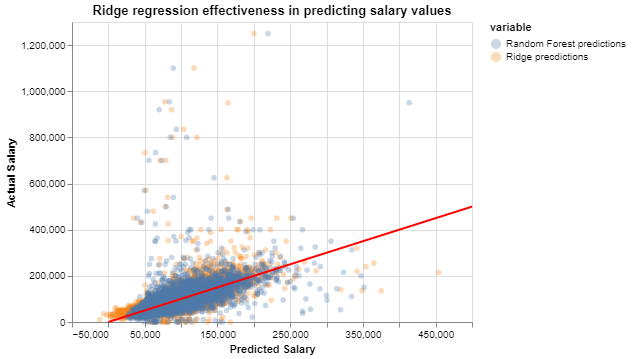

In [73]:
from altair_saver import save

point = alt.Chart(salary_data, title='Ridge regression effectiveness in predicting salary values').mark_circle(opacity = 0.3).encode(
    alt.X("value", title="Predicted Salary"),
    alt.Y('y_actual', title="Actual Salary"),
    color = "variable"
)

line = pd.DataFrame({
    'x': [0, 500000],
    'y':  [0, 500000],
})

line_plot = alt.Chart(line).mark_line(color= 'red').encode(
    x= 'x',
    y= 'y',
)

chart = point + line_plot
chart